In [1]:
# !pip install matplotlib
# !pip install pandas
# !pip install numpy
# !pip install tensorboard
# !pip install tqdm

# resnet 18

import and add name

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.models as models
import os
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm import tqdm
from net import *
from PIL import Image


import torch.nn.functional as F
import torch.nn as nn
from util import get_transform, get_acc


hyperparameters

In [3]:
writer = SummaryWriter ('tf_logs_exp') 
batch_Size = 32
learning_rate = 3e-4
weight_decay = 1e-3
num_epoch = 50


 Define the model used

In [4]:
#model = get_resnext() 
#model = get_resnet()
#model = get_resnet18()

model = get_resnet18_1()

Define the name of the training weights of the saved model

In [5]:
#model_path = r'model_save/resnet.pth' 
# model_path = r'model_save/resnext.pth'
model_path = r'model_save/resnet18.pth'

In [6]:
get_resnet18

<function net.get_resnet18()>

Use gpu if not can use cpu

In [7]:
def get_device():
    return 'cuda' if torch.cuda.is_available () else 'cpu'

Check if gpu is used correctly

In [8]:
device = get_device ()
print (device)

cuda


Import the correct address for train and valid

In [9]:
model = model.to (device)
train_path = r'dataset/train'
val_path = r'dataset/valid'

Do a transform on the data

In [10]:
# transforms_train = transforms.Compose (
#     [
#         transforms.Resize ([224, 224]),
#         transforms.ToTensor ()
#     ])

# transforms_vaild = transforms.Compose (
#     [
#         transforms.Resize ([224, 224]),
#         transforms.ToTensor ()
#     ])

train_dataset = torchvision.datasets.ImageFolder (root=train_path, transform=get_transform())
val_dataset = torchvision.datasets.ImageFolder (root=val_path, transform=get_transform())

print ('The dataset corresponding labels are:{}'.format (train_dataset.class_to_idx))

The dataset corresponding labels are:{'Albedo': 0, 'CC': 1, 'CuChulainn': 2, 'Gilgamesh': 3, 'Sesshomaru': 4}


In [11]:
train_loader = DataLoader (dataset=train_dataset, batch_size=batch_Size, shuffle=True, num_workers=2)
val_loader = DataLoader (dataset=val_dataset, batch_size=batch_Size, shuffle=True, num_workers=2)
print(train_loader,val_loader)

<torch.utils.data.dataloader.DataLoader object at 0x0000022E0894E860> <torch.utils.data.dataloader.DataLoader object at 0x0000022E0894E800>


In [12]:
len(val_loader)*32

384

In [13]:
batch_images, batch_labels=next(iter(train_loader))

In [14]:
print(f"Image shape: {batch_images.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {batch_labels.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [15]:
class_name=train_dataset.classes

In [16]:
class_name

['Albedo', 'CC', 'CuChulainn', 'Gilgamesh', 'Sesshomaru']

C:\Users\21083\AppData\Local\Temp\ipykernel_10992\2439748209.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plot_img=torch.tensor(data=batch_images[i].permute(1, 2, 0))


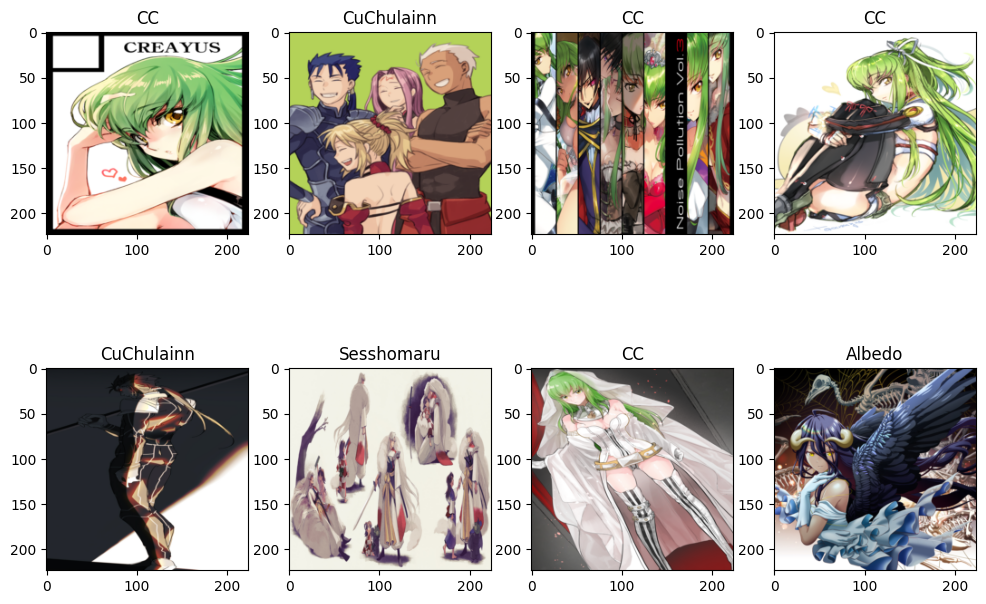

In [17]:
plt.figure(figsize=(12,8))

for i in range(8):
    plot_img=torch.tensor(data=batch_images[i].permute(1, 2, 0))
    plt.subplot(2,4,i+1)
    plt.title(class_name[batch_labels[i]])
    plt.imshow(plot_img)     

In [18]:
# 定义交叉熵损失函数，adam优化器，cos余弦学习率调整
criterion = nn.CrossEntropyLoss ()
optimizer = torch.optim.Adam (model.parameters (), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR (optimizer, T_max=10, eta_min=0, last_epoch=-1)

n_epochs = num_epoch

best_acc = 0.0

train_acc_list = []
train_loss_list = []

valid_loss_list = []
valid_acc_list = []


In [19]:
# 开始周期训练
for epoch in tqdm(range(n_epochs)):
    # ---------- Training ----------

    model.train ()
    train_loss = []
    train_accs = []

    i = 0

    for batch in tqdm (train_loader):

        imgs, labels = batch
        imgs = imgs.to (device)
        labels = labels.to (device)
        logits = model (imgs)
        # 计算loss
        loss = criterion (logits, labels)

        # 网络更新
        optimizer.zero_grad ()
        loss.backward ()
        optimizer.step ()
        scheduler.step ()

        #if (i % 500 == 0):
            #print ("learning_rate:", scheduler.get_last_lr ()[0])
       # i = i + 1

        acc = (logits.argmax (dim=-1) == labels).float ().mean ()

        train_loss.append (loss.item ())
        train_accs.append (acc.item ())

    train_loss = sum (train_loss) / len (train_loss)
    train_acc = sum (train_accs) / len (train_accs)

    print (f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    train_acc_list.append (train_acc)
    train_loss_list.append (train_loss)
    

    # 记录到tensorboard
    writer.add_scalar ('Train Loss ', train_acc, epoch)
    writer.add_scalar ('Train Accuracy ', train_loss, epoch)

    # ---------- Validation ----------
    model.eval ()

    valid_loss = []
    valid_accs = []

    for batch in tqdm (val_loader):
        imgs, labels = batch

        with torch.no_grad ():
            logits = model (imgs.to (device))

        loss = criterion (logits, labels.to (device))

        acc = (logits.argmax (dim=-1) == labels.to (device)).float ().mean ()

        valid_loss.append (loss.item ())
        valid_accs.append (acc)

    valid_loss = sum (valid_loss) / len (valid_loss)
    valid_acc = sum (valid_accs) / len (valid_accs)

    print (f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    valid_loss_list.append (valid_loss)
    valid_acc_list.append (valid_acc)

    # 保留在验证集上最好的模型
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save (model.state_dict (), model_path)
        print ('saving model with acc {:.3f}'.format (best_acc))

    writer.add_scalar ('Valid Loss ', valid_acc, epoch)
    writer.add_scalar ('Valid Accuracy ', valid_loss, epoch)


100%|██████████| 57/57 [00:37<00:00,  1.50it/s]


[ Train | 001/020 ] loss = 1.23140, acc = 0.55842


  5%|▌         | 1/20 [00:46<14:40, 46.37s/it]

[ Valid | 001/020 ] loss = 1.52462, acc = 0.40052
saving model with acc 0.401


100%|██████████| 57/57 [00:37<00:00,  1.53it/s]


[ Train | 002/020 ] loss = 1.02083, acc = 0.61879


 10%|█         | 2/20 [01:32<13:49, 46.11s/it]

[ Valid | 002/020 ] loss = 1.16585, acc = 0.49427
saving model with acc 0.494


100%|██████████| 57/57 [00:40<00:00,  1.42it/s]


[ Train | 003/020 ] loss = 0.87443, acc = 0.67970


 15%|█▌        | 3/20 [02:21<13:24, 47.30s/it]

[ Valid | 003/020 ] loss = 1.01545, acc = 0.62483
saving model with acc 0.625


100%|██████████| 57/57 [00:37<00:00,  1.52it/s]


[ Train | 004/020 ] loss = 0.79447, acc = 0.70590


 20%|██        | 4/20 [03:07<12:30, 46.93s/it]

[ Valid | 004/020 ] loss = 1.16862, acc = 0.57309


100%|██████████| 57/57 [00:38<00:00,  1.49it/s]


[ Train | 005/020 ] loss = 0.84834, acc = 0.68263


 25%|██▌       | 5/20 [03:54<11:42, 46.83s/it]

[ Valid | 005/020 ] loss = 1.13678, acc = 0.51649


100%|██████████| 57/57 [00:37<00:00,  1.50it/s]


[ Train | 006/020 ] loss = 0.72331, acc = 0.72935


 30%|███       | 6/20 [04:40<10:53, 46.66s/it]

[ Valid | 006/020 ] loss = 0.82674, acc = 0.70174
saving model with acc 0.702


100%|██████████| 57/57 [00:39<00:00,  1.45it/s]


[ Train | 007/020 ] loss = 0.67071, acc = 0.74086


 35%|███▌      | 7/20 [05:28<10:11, 47.02s/it]

[ Valid | 007/020 ] loss = 1.61105, acc = 0.44774


100%|██████████| 57/57 [00:39<00:00,  1.46it/s]


[ Train | 008/020 ] loss = 0.65662, acc = 0.77150


 40%|████      | 8/20 [06:15<09:26, 47.23s/it]

[ Valid | 008/020 ] loss = 0.81136, acc = 0.70104


100%|██████████| 57/57 [00:37<00:00,  1.51it/s]


[ Train | 009/020 ] loss = 0.54594, acc = 0.80312


 45%|████▌     | 9/20 [07:02<08:37, 47.06s/it]

[ Valid | 009/020 ] loss = 0.80536, acc = 0.71806
saving model with acc 0.718


100%|██████████| 57/57 [00:39<00:00,  1.46it/s]


[ Train | 010/020 ] loss = 0.45453, acc = 0.84150


 50%|█████     | 10/20 [07:50<07:52, 47.22s/it]

[ Valid | 010/020 ] loss = 1.14534, acc = 0.64931


100%|██████████| 57/57 [00:39<00:00,  1.45it/s]


[ Train | 011/020 ] loss = 0.41690, acc = 0.85502


 55%|█████▌    | 11/20 [08:37<07:06, 47.36s/it]

[ Valid | 011/020 ] loss = 1.52970, acc = 0.60174


100%|██████████| 57/57 [00:39<00:00,  1.44it/s]


[ Train | 012/020 ] loss = 0.32988, acc = 0.88919


 60%|██████    | 12/20 [09:26<06:21, 47.67s/it]

[ Valid | 012/020 ] loss = 0.95262, acc = 0.72882
saving model with acc 0.729


100%|██████████| 57/57 [00:38<00:00,  1.47it/s]


[ Train | 013/020 ] loss = 0.22408, acc = 0.92952


 65%|██████▌   | 13/20 [10:13<05:32, 47.48s/it]

[ Valid | 013/020 ] loss = 1.20754, acc = 0.65903


100%|██████████| 57/57 [00:38<00:00,  1.49it/s]


[ Train | 014/020 ] loss = 0.16352, acc = 0.94268


 70%|███████   | 14/20 [11:00<04:45, 47.55s/it]

[ Valid | 014/020 ] loss = 1.45495, acc = 0.64080


100%|██████████| 57/57 [00:37<00:00,  1.52it/s]


[ Train | 015/020 ] loss = 0.21836, acc = 0.91953


 75%|███████▌  | 15/20 [11:46<03:55, 47.11s/it]

[ Valid | 015/020 ] loss = 1.13517, acc = 0.68767


100%|██████████| 57/57 [00:37<00:00,  1.50it/s]


[ Train | 016/020 ] loss = 0.14847, acc = 0.95121


 80%|████████  | 16/20 [12:33<03:07, 46.85s/it]

[ Valid | 016/020 ] loss = 1.13318, acc = 0.69913


100%|██████████| 57/57 [00:43<00:00,  1.32it/s]


[ Train | 017/020 ] loss = 0.05717, acc = 0.98739


 85%|████████▌ | 17/20 [13:25<02:25, 48.39s/it]

[ Valid | 017/020 ] loss = 1.17957, acc = 0.69097


100%|██████████| 57/57 [00:41<00:00,  1.38it/s]


[ Train | 018/020 ] loss = 0.02858, acc = 0.99397


 90%|█████████ | 18/20 [14:15<01:37, 48.83s/it]

[ Valid | 018/020 ] loss = 1.08580, acc = 0.70538


100%|██████████| 57/57 [00:43<00:00,  1.31it/s]


[ Train | 019/020 ] loss = 0.01984, acc = 0.99452


 95%|█████████▌| 19/20 [15:07<00:49, 49.78s/it]

[ Valid | 019/020 ] loss = 1.11241, acc = 0.72517


100%|██████████| 57/57 [00:42<00:00,  1.35it/s]


[ Train | 020/020 ] loss = 0.05766, acc = 0.98422


100%|██████████| 20/20 [15:57<00:00, 47.88s/it]

[ Valid | 020/020 ] loss = 1.68644, acc = 0.55521


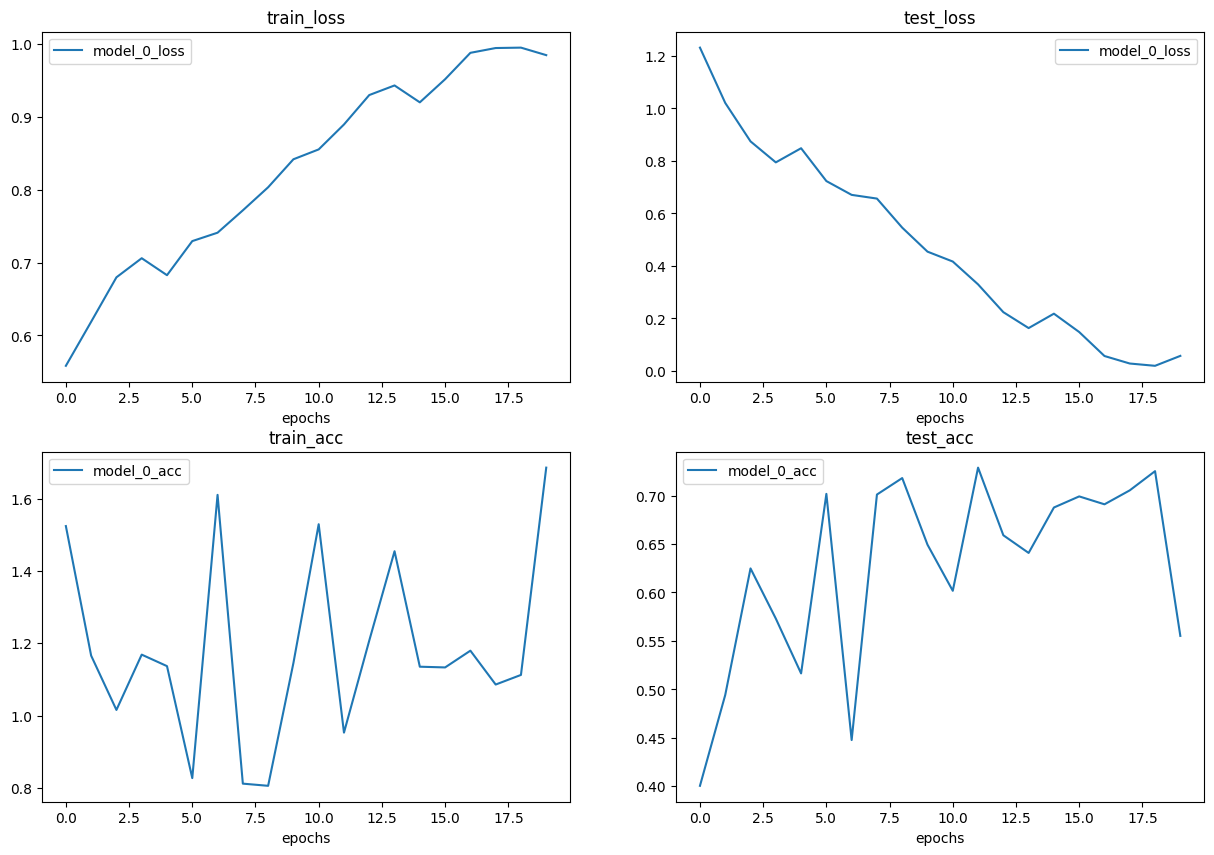

In [20]:
# ------ Complete subplot functions in the following lines -------
plt.figure(figsize=(15, 10))

# Plot train loss with label, title, legend
plt.subplot(2, 2, 1)
plt.plot(train_acc_list,label='model_0_loss')  
plt.title('train_loss')
plt.xlabel('epochs')
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(train_loss_list,label='model_0_loss')  
plt.title('test_loss')
plt.xlabel('epochs')
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(valid_loss_list,label='model_0_acc') 
plt.title('train_acc')
plt.xlabel('epochs')
plt.legend()

valid_accuracy_list=[]
for i in valid_acc_list:
    valid_accuracy_list.append(i.tolist())
    
# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(valid_accuracy_list,label='model_0_acc')   

plt.title('test_acc')
plt.xlabel('epochs')
plt.legend()


In [21]:
valid_accuracy_list=[]
for i in valid_acc_list:
    valid_accuracy_list.append(i.tolist())

In [22]:
valid_accuracy_list

[0.40052086114883423,
 0.49427086114883423,
 0.6248264312744141,
 0.5730903148651123,
 0.5164930820465088,
 0.7017361521720886,
 0.4477430582046509,
 0.7010416984558105,
 0.7180556058883667,
 0.6493055820465088,
 0.6017361283302307,
 0.7288194894790649,
 0.6590278148651123,
 0.6407986283302307,
 0.6876736879348755,
 0.699131965637207,
 0.6909722685813904,
 0.7053819894790649,
 0.7251736521720886,
 0.5552083253860474]

In [23]:
# 建立模型并读取训练好的权重

#model = get_resnext() # 定义使用的模型
#model = get_resnet()
model = get_resnet18()
#model_path = r'model_save/resnet.pth' #定义保存模型训练权重的名称
# model_path = r'model_save/resnext.pth'
model_path = r'model_save/resnet18.pth'


In [24]:
test_path = r'dataset/test'


test_dataset = torchvision.datasets.ImageFolder (root=test_path, transform=get_transform())

test_loader = DataLoader (dataset=test_dataset, batch_size=32, shuffle=True)

In [25]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear (num_ftrs, 5)
model.load_state_dict (torch.load (model_path))
model = model.to (device)

criterion = nn.CrossEntropyLoss ()

model.eval ()
test_loss = []
test_accs = []


In [26]:
test_acc = get_acc(model, test_loader, criterion)
print (f"Test  acc = {test_acc:.5f}")

100%|██████████| 12/12 [00:14<00:00,  1.18s/it]

Test  acc = 0.71701


In [27]:
# 对单张图像进行预测
def model_test(model, img_path):
    device = 'cuda'
    data_transform = transforms.Compose ([
        transforms.Resize ((224, 224)),
        transforms.ToTensor (),
    ])

    img = Image.open (img_path)
    img = data_transform (img)
    # 增加一维batch
    img = torch.unsqueeze (img, dim=0)

    model.eval ()
    with torch.no_grad ():
        output = model (img.to (device))
        number = torch.argmax (output.to ('cpu')[0]).numpy ().item ()
    #         print(answer)
    return number



In [28]:
if __name__ == '__main__':
    # 建立模型并读取训练好的权重
    model = get_resnet18 ()
    device = get_device ()
    model.to (device)

    model_path = r'model_save/resnet18.pth'
    model.load_state_dict (torch.load (model_path))

    # 标签到名称的字典
    label_dict = {0:'Albedo', 1:'CC', 2:'CuChulainn', 3:'Gilgamesh', 4:'Sesshomaru'}
    img_pre_labels=[]
    count = 0
    for i in os.listdir(r'prediction'):
        img_path = r'prediction'+'/'+i
        img_pre_label = label_dict [model_test (model, img_path)]
        img_pre_labels.append(img_pre_label)

        print ('picture {} name is： {}'.format(i,img_pre_labels[count]))
        count+=1

picture 121.jpg name is： CuChulainn
picture 14.jpg name is： Sesshomaru
picture 151.jpg name is： Sesshomaru
picture 212.jpg name is： Sesshomaru
picture 48454aef65a50e3326574f8193a5728b.jpg name is： Gilgamesh
picture 623bb4fc-48fb-48f9-9133-caacc0b99f60.jpg name is： Albedo
picture 712.png name is： CC
picture 713.png name is： CC
picture 81+8S5bSrOL._AC_SL1500_.jpg name is： Gilgamesh


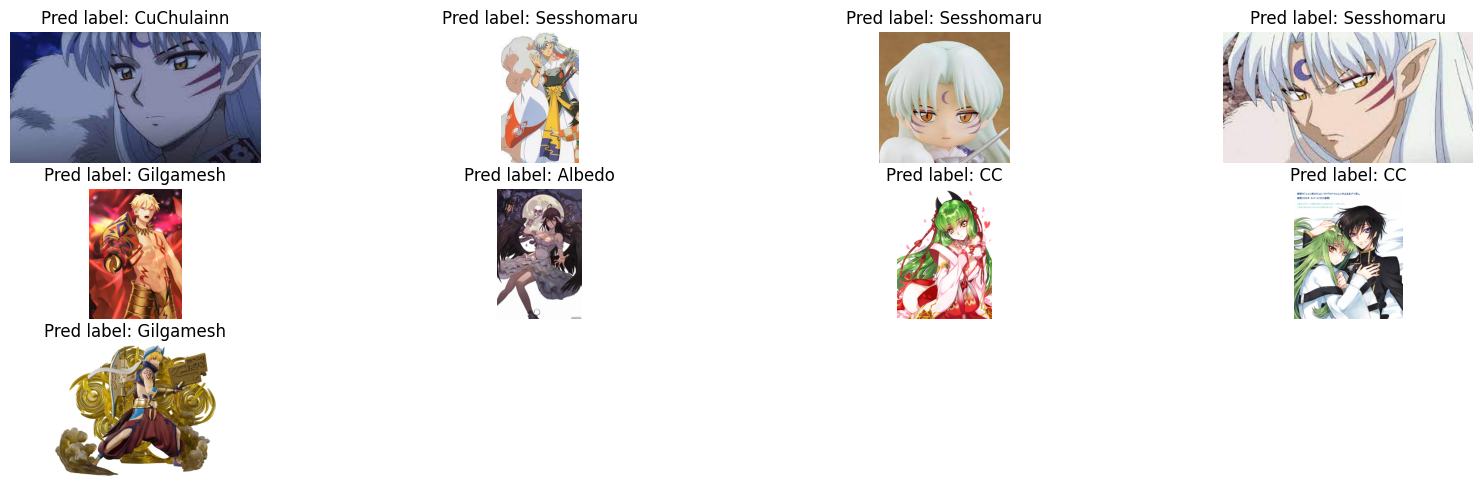

In [29]:
plt.figure(figsize=[20,20])    
count1=1
for i in os.listdir(r'prediction'):
        custom_image = r'prediction'+'/'+ i
        img = torchvision.io.read_image(custom_image)
        plt.subplot(10,4,count1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"Pred label: {img_pre_labels[count1-1]}")
        plt.axis(False)
        count1+=1